# 🐍 Practice n°4: classification
The objective of this session is to learn about classification task. You will have to
build a new model only using the text review.

In order to apply classification models, we need to change the target definition. We
will divide the reviews into good or bad using the rating.

So our goal is to have a model, a function, that takes text as input and output a
label/class (good review or bad review).

$$f(text) = label$$

The data are the same as those used for the regression (*source* [*ratebeer dataset description*](https://snap.stanford.edu/data/web-RateBeer.html)).


Here are the main steps of the notebook :

1. What is classification ?
2. Focus on logistic regression
3. Preparation
4. Binary target definition
5. Text cleaning
6. Modelling
  - 6.1 First model using CountVectorizer
  - 6.2 Choose the right metrics
  - 6.3 Second model using TF-IDF

## 1. What is classification ?

Classification in machine learning consists of mathematical methods that allow to
predict a discrete outcome (y) based on the value of one or more predictor variables
(x).


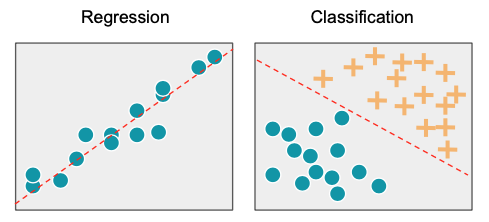



There are several types of classification :


* **Binary classification**: the task of classifying the data into two groups (each
called class).
> Example: an email can be classified as belonging to one of two classes: "spam" and
"not spam".

* **Multi-class classification**: the task of classifying the data into N groups
(N > 2).
> Example: an image can be classified as belonging to one of N classes: "cat", "dog",
"cow" or "fish".

* **Multi-label classification**: this is a generalization of multi-class
classification problem where an instance can be assigned to multiple classes.
> Example: a movie can be classified as belonging to one or more classes: "action",
"adventure", "thriller" or all simultaneously.


In this session, we will focus on the **Binary classification**.

## 2. Focus on logistic regression

As seen in the last session, we can represent the link between the explicatives
variables and the target to be predicted as follows

$$\hat{y} = \beta_0 + \beta_1x_1 + \beta_2x_2 + ... + \beta_nx_n$$

The difference here is that the target is not a continous variable (rating) but a
discrete one (good review / bad review). If we limit ourselves to this model, the
linear combination of each input will give an unbounded number that does not allow us
to classify the review into good or bad.

To transform the number provided by the linear combination into a classification, we
use a function called `sigmoid function` which has the interesting property of
transforming the numbers passed inside into numbers between 0 and 1.


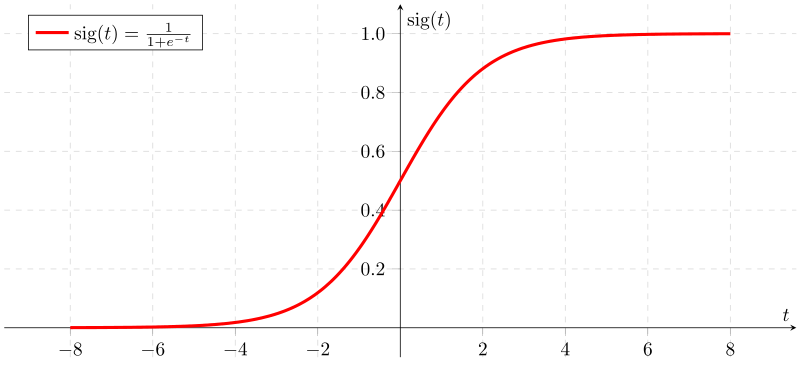

After passing the linear combination through this function, the output will be
considered as a probability $P$ and using a threshold (0.5 in general), the review
can be classified as bad review, if $P < 0.5$, or good review, if $P >= 0.5$.

_This threshold can be modified in some contexts_

Then during the training phase, we will compute the parameters β in order to optimize
the `Maximum Likelihood` i.e., for a given bad review, we want the probalility
estimated by our model to be minimal and for a given good review, we want the
probalility estimated by our model to be maximal.

## 3. Preparation

### Install & import modules

In [ ]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, recall_score, precision_score, classification_report
import nltk
from nltk.corpus import stopwords
import seaborn as sns
nltk.download('stopwords')

pd.set_option('display.max_colwidth', None)
pd.set_option("display.precision", 2)
sns.set_style("whitegrid")

### Read remote dataset

In [ ]:
file_url = "https://github.com/ML-boot-camp/ratebeer/raw/master/data/ratebeer_sample_enriched.parquet"
df_full = pd.read_parquet(file_url)

In [ ]:
df_full.head(5)

## 4. Binary target definition

Filter the data using only 1000 reviews and then explore some reviews


In [ ]:
# Filter the data
N_rows = 1000
df = df_full[["text", "rating", "is_good"]].sample(N_rows, random_state=42)

In [ ]:
# Display some text reviews

print("GUESS THE RATING ?")
df_example = df.sample(n=1)
df_example.text

In [ ]:
print(f"RATING: {df_example.rating.iloc[0]}")

To begin with a binary classification problem, we will bin the target into 2 classes:
bad review and good review

First, look at the target distribution and choose a threshlold to identify good
reviews from the rest.

In [ ]:
# display the target distribution
df.rating.astype(int).plot(kind="hist")

You can play with the **rating_threshold** and look at the new target distribution. 

In [ ]:
# Create a binary target and display the target distribution
rating_threshold = 16 #%%%
(df.rating >= rating_threshold).astype(int).value_counts(normalize=True)

Usually the threshold is defined by looking manually at the data: annotating a few
reviews as "good" or "bad" and see which ratings they had.
E.g: on google maps a "good" review is above 4 stars (out of 5 stars).
For simplicity, here we'll use the `is_good` binary target defined during the data
engineering phase.

In [ ]:
# Create a binary target and display the target distribution
rating_threshold = df.rating.median() #%%%
(df.rating >= rating_threshold).astype(int).value_counts(normalize=True)

## 5. Text cleaning

#### From text reviews to numerical vectors

Before training some models, the first step is to transform text into numbers :

from
```
f(raw_text) = rating_classe
```

to
```
f(numerical_vector_representing_text) = rating_classe
```

Indeed, we can't direclty feed an algortihm with text.

For example:

```
Wow, that beer is SOOOO good :O !!
```

must be transformed to something like:
```
[3, 4, 21, 0, 0, 8, 19]
```
where the values of the vector contain the meaning of the text. Knowing that the
closer texts are in terms of meaning, the more closed their vector representation is
too. Moreover, it is often more convenient to convert texts of different sizes into
vectors of fixed size.


For example:

```
"Wow, that beer is SOOOO good :O !!"
-> characters : 34
-> vector (1x7) : [3, 4, 21, 0, 0, 8, 19]
```
```
"This beer is very tasty"
-> characters : 23
-> vector (1x7) : [3, 4, 20, 0, 0, 7, 19]
```
But:
```
"It's not a beer, just motor oil at best."
-> characters : 40
-> vector (1x7) : [0, 4, 1, 12, 14, 0, 0]
```

#### From raw text reviews to clean list of words

Before converting text to numerical vector, the first step is to clean the text to
keep only the pertinent information.

Here are the following cleaning steps that we will apply on the reviews:
1. Convert letter to lowercase
```
"Wow, that beer is SOOOO good :O !!" -> "wow, that beer is soooo good :o !!"
```
2. Remove the punctuation letter to lowercase
```
"wow, that beer is soooo good :o !!" -> "wow that beer is soooo good"
```
3. Transform the text into tokens
```
"wow that beer is soooo good" -> ["wow", "that", "beer", "is", "soooo", "good"]
```
4. Remove the stopwords, the most common english words that often bring noise to the
models.
```
["wow", "that", "beer", "is", "soooo", "good"] -> ["wow", "beer", "soooo", "good"]
```

5. To go further, some techniques can be used to reduce the forms of each word into a
common base or root. This can be done with:

(1) **Stemming** is the process of eliminating affixes (suffixed, prefixes, infixes,
circumfixes) from a word in order to obtain a word stem.

> am, are, is  $\Rightarrow$  be

(2) **Lemmatization** is related to stemming, differing in that lemmatization is able
to capture canonical forms based on a word's lemma.

> book, books, book's, book'  $\Rightarrow$  book

_The steps presented here are just the most basic, many different things can be
applied to the cleaning part of the text._

In [ ]:
def convert_text_to_lowercase(df, colname):
    df[colname] = (
        df[colname]
        .str.lower() #%%%
    )
    return df

def not_regex(pattern):
        return r"((?!{}).)".format(pattern)

def remove_punctuation(df, colname):
    df[colname] = df[colname].str.replace("\n", " ")
    df[colname] = df[colname].str.replace("\r", " ")
    alphanumeric_characters_extended = "(\\b[-/]\\b|[a-zA-Z0-9])"
    df[colname] = df[colname].str.replace(not_regex(alphanumeric_characters_extended), " ")
    return df

def tokenize_sentence(df, colname):
    df[colname] = df[colname].str.split()
    return df

def remove_stop_words(df, colname):
    stop_words = stopwords.words("english")
    df[colname] = df[colname].apply(lambda x: [word for word in x if word not in stop_words])
    return df

def reverse_tokenize_sentence(df, colname):
    df[colname] = df[colname].map(lambda word: " ".join(word))
    return df


def text_cleaning(df, colname):
    """
    Takes in a string of text, then performs the following:
    1. convert text to lowercase
    2. remove punctuation and new line characters "\n"
    3. Tokenize sentences
    4. Remove all stopwords
    5. convert tokenized text to text
    """
    df = (
        df
        .pipe(convert_text_to_lowercase, colname) #%%%
        .pipe(remove_punctuation, colname) #%%%
        .pipe(tokenize_sentence, colname) #%%%
        .pipe(remove_stop_words, colname) #%%%
        .pipe(reverse_tokenize_sentence, colname) #%%%
    )
    return df

In [ ]:
# Apply data cleaning
df_cleaned = text_cleaning(
    df, #%%%
    "text"
)

In [ ]:
# Control the cleaning
df_cleaned.head()

We still have to transform the list of tokens to a fixed size numerical vector

For that, we will use 2 very common techniques : CountVectorizer and TF-IDF

**Definition:**

**CountVectorizer** is used to convert a collection of text documents to a vector of
token counts. 

Example:
```
["beer", "most", "tasty", "beer", "world"]
```

Will be transformed into ⬇

| beer | most | tasty | world |
|------|------|-------|-------|
| 2    | 1    | 1     | 1     |

In practice, you have to define a vocabulary size and each text will be transform into
a vector of size [1 x vocabulary size]. Consequently, zeros will be added to the
vector for each word present in the corpus vocabulary but missing in the specific
review. 
The vocabulary space is defined using term frequency across the corpus: the most
frequent words are kept.

**TF-IDF** or **term frequency–inverse document frequency**, is a numerical statistic
that is intended to reflect how important a word is to reflect how important a word is
to a document in a collection or corpus.

**TF: Term Frequency**, which measures how frequently a term occurs in a document.
Since every document is different in length, it is possible that a term would appear
much more times in long documents than shorter ones. Thus, the term frequency is often
divided by the document length (aka. the total number of terms in the document) as a
way of normalization: 
     
```
TF(t) = (Nbr of times term t appears in a document) / (Total nbr of terms in the
document)
```
   
**IDF: Inverse Document Frequency**, which measures how important a term is. While
computing TF, all terms are considered equally important. However it is known that
certain terms, such as "is", "of", and "that", may appear a lot of times but have
little importance. Thus we need to weigh down the frequent terms while scale up the
rare ones, by computing the following: 
     
```
IDF(t) = log(Total number of documents / Number of documents with term t in it)
```

Example:

Consider a document containing 100 words wherein the word _book_ appears 3 times. The
term frequency (i.e., tf) for cat is:
```
TF(t) = (Nbr of times term t appears in a document) / (Total nbr of terms in the
document)
      = 3 / 100
      = 0.03
```
Now, assume we have 10 million documents and the word _book_ appears in one thousand
of these. Then, the inverse document frequency (i.e., idf) is calculated as
```
IDF(t) = log(Total number of documents / Number of documents with term t in it)
       = log(10,000,000 / 1,000)
       = 4
```
Thus, the Tf-idf weight is the product of these quantities:
```
Tf-IDF = TF(t) * IDF(t)
       = 0.03 * 4
       = 0.12
```

## Split the data into train/test sets

Before applying these transormation on the text, we will just split the data for the
modelling part.

Keep 20% of the data for the test dataset

In [ ]:
TARGET = "is_good" #%%%
FEATURE = "text" #%%%

x_train, x_test, y_train, y_test = train_test_split(
    df_cleaned[FEATURE], #%%%
    df_cleaned[TARGET], #%%%
    test_size=0.2,
    random_state=42)

## 6. Modelling

### 6.1 First model using CountVectorizer

Transform the text reviews into numerical vectors by counting the number of words in each reviews. Use the `scikit-learn` library.

In order not to bring information from the train set into the test set, you must train the `CountVectorizer` on the train set and apply it to the test set.

Hint:
 - [`sklearn.feature_extraction.text.CountVectorizer`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html)

In [ ]:
# Define the vocabulary size to 100
count_vectorizer = CountVectorizer(
    analyzer="word",
    max_features=100 #%%%
    )

In [ ]:
# Apply the CountVectorizer and check the results on some rows
count_vectorizer.fit(x_train)

x_train_features = count_vectorizer.transform(x_train).toarray()
x_test_features = count_vectorizer.transform(x_test).toarray()

In [ ]:
x_train_features[0]

In [ ]:
x_train.iloc[0]

The next step is to define the model that will use in input the vectors from the the
`CountVectorizer`. We will use a logistic regression model, using again the
`scikit-learn` library.

In order to produce cleaner code, we can combine these 2 steps (CountVectorizer and
Logistic regression) into a single pipeline.

- Initialize the `CountVectorizer`
- Initialize the `LogisticRegression`
- Define your `Pipeline` object with these 2 steps
- Fit the `Pipeline`

Hint:
- [`sklearn.linear_model.LogisticRegression`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)
- [`sklearn.pipeline.Pipeline`](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html)

In [ ]:
# Initialize the CountVectorizer
count_vectorizer = CountVectorizer(
    analyzer="word",
    max_features=100
    )

# Initialize the logistic regression
logit = LogisticRegression(solver="lbfgs", verbose=2, n_jobs=-1)

# Combine them into a Pipeline object
pipeline_cv = Pipeline([
    ("vectorizer", count_vectorizer), #%%%
    ("model", logit)]) #%%%

# Fit the Pipeline
pipeline_cv.fit(x_train, y_train)

Now you can make predictions on the test set

In [ ]:
# predictions
y_pred_cv = pipeline_cv.predict(x_test)

How to evaluate our model ? 

`Accuracy` is the most intuitive performance measure and it is simply a ratio of
correctly predicted observation to the total observations

In [ ]:
# Compute accuracy
print(f"model accuracy : {accuracy_score(y_pred_cv, y_test)} %")

What is you opinion about the `accuracy` score ?

One may think that, if we have high accuracy then our model is best. Yes, accuracy is
a great measure but only when you have symmetric datasets where values of false
positive and false negatives are almost same. Therefore, you have to look at other
parameters to evaluate the performance of your model.

One might think that if we have high accuracy, our model is the best. Yes, accuracy is
an excellent measure, but only when you have balanced data (i.e. an equivalent
representation of each class in the data).

Let's do a test with a reference model to show how accuracy can be a source of error 
when evaluating a model: Create a model that predict everytime the most frequent class
and compare the results.

In [ ]:
# Baseline model: predict the most-frequent class
y_pred_baseline = [y_test.mode()[0]] * len(y_test)

# Compute accuracy
print(f"model baseline accuracy : {accuracy_score(y_pred_baseline, y_test)} %")

Accuracy are closed, but the last model is completely idiot !

In case of an imbalanced target (let's say 99% zeros), the accuracy of this dumb
model will be 99% !

Therefore, you need to look at other metrics to evaluate the performance of your
model.

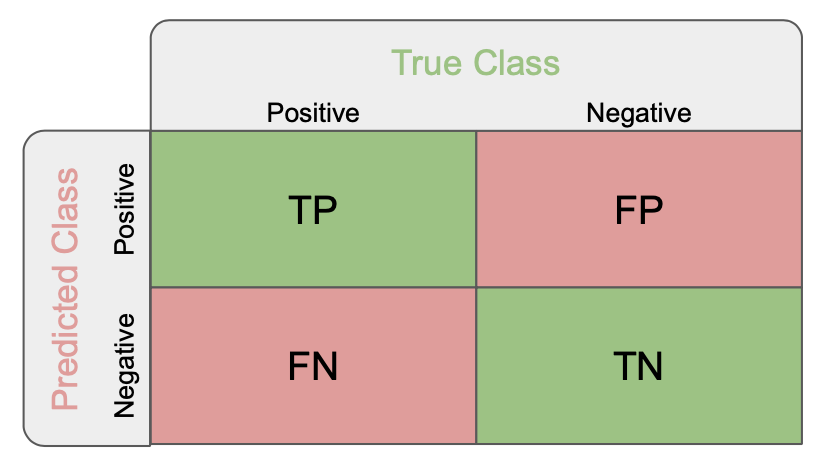

### 6.2 Choose the right metrics

We need now define other metrics to evaluate our model.

- **True Positives** (TP): these are the correctly predicted positive values which
means that the value of actual class is yes and the value of predicted class is also
yes.

- **True Negatives** (TN): these are the correctly predicted negative values which
means that the value of actual class is no and value of predicted class is also no.

- **False Positives** (FP): when actual class is no and predicted class is yes.

- **False Negatives** (FN): when actual class is yes but predicted class in no.

- **Accuracy**: the ratio of correctly predicted observation to the total
observations.
> Accuracy = $\frac{TP+TN}{TP+FP+FN+TN}$

- **Precision**: Precision is the ratio of correctly predicted positive observations
to the total predicted positive observations. High precision relates to the low false
positive rate.
> Precision = $\frac{TP}{TP+FP}$

- **Recall (Sensitivity)**: Recall is the ratio of correctly predicted positive 
observations to the all observations in actual class - yes.
> Recall = $\frac{TP}{TP+FN}$

- **F1 score**: F1 Score is the weighted average of Precision and Recall. Therefore, 
this score takes both false positives and false negatives into account. Intuitively it
is not as easy to understand as accuracy, but F1 is usually more useful than accuracy,
especially if you have an uneven class distribution.
> F1 Score = $2* \frac{Recall * Precision}{Recall + Precision}$

Let's now compare again our 2 models !

First, plot the confusion matrix, the precision, recall and f1 score for each model.
You can also print the classification report of scikit learn that sums up the main
classification metrics.

Hint:
- [`sklearn.metrics.confusion_matrix`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html)
- [`sklearn.metrics.recall_score`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.recall_score.html)
- [`sklearn.metrics.precision_score`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_score.html#sklearn.metrics.precision_score)
- [`sklearn.metrics.f1_score`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html)
- [`sklearn.metrics.classification_report`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html)


In [ ]:
# Confusion matrices
print(f"Confusion matrix of the first model: \n {confusion_matrix(y_test, y_pred_cv)}")
print(f"Confusion matrix of the baseline model: \n {confusion_matrix(y_test, y_pred_baseline)}")

In [ ]:
# Evaluate the first model
print(f"first model precision : {precision_score(y_pred_cv, y_test):.{3}f}%")
print(f"first model recall    : {recall_score(y_pred_cv, y_test)}%")
print(f"first model f1 score  : {f1_score(y_pred_cv, y_test):.{3}f}%\n")

# Evaluate the baseline model
print(f"baseline model precision : {precision_score(y_pred_baseline, y_test)}%")
print(f"baseline model recall    : {recall_score(y_pred_baseline, y_test)}%")
print(f"baseline model f1 score  : {f1_score(y_pred_baseline, y_test)}%")

In [ ]:
# Classification report
print(classification_report(
    y_test, y_pred_cv #%%%
))

In [ ]:
# Classification report
print(classification_report(y_test, y_pred_baseline))

### 6.3 Second model using TF-IDF Vectorizer

In this last section, you will use a better approach in term of vectorization: TF-IDF

Scikit-learn provide the `TfidfVectorizer` that can be used in the same way as
`CountVectorizer`.

Hint:
 - [`sklearn.feature_extraction.text.TfidfVectorizer`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html)

In [ ]:
# Initialize the TF-IDF
tfidf_vectorizer = TfidfVectorizer(
    analyzer='word',
    max_features=100 #%%%
    )

# Apply the TfidfVectorizer and check the results on some rows
tfidf_vectorizer.fit(x_train)

x_train_features = tfidf_vectorizer.transform(x_train).toarray()
x_test_features = tfidf_vectorizer.transform(x_test).toarray()

In [ ]:
x_train_features[0]

In [ ]:
x_train.iloc[0]

You can now combine the vectorizer to a logistic regression in a single pipeline

In [ ]:
# Initialize the TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(
    analyzer='word',
    max_features=100
    )

# Initialize the logistic regression
logit = LogisticRegression(solver='lbfgs', verbose=2, n_jobs=-1)

# Combine them into a Pipeline object
pipeline_tfidf = Pipeline([
    ('vectorizer', tfidf_vectorizer), #%%%
    ('model', logit)]) #%%%

# Fit the Pipeline
pipeline_tfidf.fit(x_train, y_train)

In [ ]:
# Predictions
y_pred_tfidf = pipeline_tfidf.predict(x_test)

# Evaluate the second model
print(f"Confusion matrix of the first model: \n {confusion_matrix(y_test, y_pred_tfidf)}")
print(f"second model precision : {precision_score(y_pred_tfidf, y_test):.{3}f}%")
print(f"second model recall    : {recall_score(y_pred_tfidf, y_test)}%")
print(f"second model f1 score  : {f1_score(y_pred_tfidf, y_test):.{3}f}%\n")

In [ ]:
# Classification report
print(classification_report(y_test, y_pred_tfidf))

### 6.4 Optimize the model

You can now try to optimize the model by changing a lot of parameters:
- Take more reviews in input
- Increase the `max_features` parameter
- Remove the most frequent words
- Try adding n-grams to the vectorizer
- Improve the text cleaning
- etc...